In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set();

In [2]:
data = '../../datasets/amazon_review/Reviews.csv'
data = pd.read_csv(data)

In [3]:
print(data.shape)

(568454, 10)


In [4]:
0.1 * 0.4

0.04000000000000001

In [5]:
568454 * 0.1 * 0.4

22738.160000000003

In [6]:
22738 < 56845

True

In [7]:
data.sample(frac=0.04, random_state=7).shape

(22738, 10)

In [8]:
# We shuffle the rows and extract 10% of the rows
df_reduced = data.sample(frac=0.1, random_state=7)
print(df_reduced.shape)
df_reduced.head()

(56845, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
246454,246455,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,We always brew Starbucks coffee at home and we...
115917,115918,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,Tasty and fresh - Just like Grandma used to ma...
57802,57803,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,"<a href=""http://www.amazon.com/gp/product/B000..."
517602,517603,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,Nice strong coffee - smooth but does have a bi...
35949,35950,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,The Vita Coco Acai & Pomegranate is the best t...


In [9]:
texts = [] # this list holds the text for each sample(row)
labels = [] # this list holds the value 0,1. 0 is nagative, 1 is positive

In [10]:
labels  = np.array([df_reduced['Score'] >= 4])[0][:].astype(int)
texts = df_reduced['Text'].values
print("The number of labels: ", len(labels))
print("The number of texts: ", len(texts))

The number of labels:  56845
The number of texts:  56845


In [11]:
print(labels[0])
print(texts[0])

1
We always brew Starbucks coffee at home and we rarely consume flavored coffee. We tried this coffee and liked it.<br /><br />If you enjoy flavored coffee, then you are likely to enjoy this coffee.<br /><br />I wish it brewed a little stronger (bold) coffee.


In [12]:
print(np.unique(labels))
print(np.bincount(labels))

sentiment_pct = np.bincount(labels) / df_reduced.shape[0] # percentage value of each sentiment 
print(sentiment_pct)

[0 1]
[12435 44410]
[ 0.21875275  0.78124725]


In [13]:
data_size = df_reduced.shape[0]

np.random.seed(7)
# shuffle data
indices = np.arange(data_size)
np.random.shuffle(indices)
texts = texts[indices]
labels = labels[indices]

reduced_data_size = int(data_size * 0.4)
reduced_texts = texts[:reduced_data_size]
reduced_labels = labels[:reduced_data_size]

print("Reduced Size is: ", reduced_texts.shape)


reduced_sentiment_pct = np.bincount(reduced_labels) / reduced_data_size # percentage value of each sentiment 
print(reduced_sentiment_pct)

Reduced Size is:  (22738,)
[ 0.22174334  0.77825666]


In [14]:

sentiment = pd.DataFrame(np.random.rand(1, 2), 
                      index=['count'],
                      columns=pd.Index(["negative", "positive"], name='sentiment'))
sentiment.iloc[0] = reduced_sentiment_pct
sentiment

sentiment,negative,positive
count,0.221743,0.778257


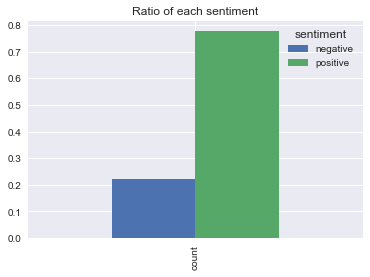

In [15]:
sentiment.plot.bar(title="Ratio of each sentiment")

<h2>Imbalanced Dataset</h2>

<h3>Thing to be noticed !! If we just classify each sample (or every samples) as "positive",
we will get about 78% classification accuracy. 78% accuracy is our baseline.</h3><br>

<h3>Shuffle and split the data into train/validation/test set</h3>

In [16]:
18190 + 4548

22738

In [17]:
# we will use 80% of data as training set, 20% as test set
train_size = int(reduced_data_size * .8)
text_train = reduced_texts[:train_size]
y_train = reduced_labels[:train_size]
text_test = reduced_texts[train_size:]
y_test = reduced_labels[train_size:]

# Sanity check
print(reduced_data_size == (len(text_train) + len(text_test)))
print("The number of training set is: ", len(text_train))
print("The number of test set is: ", len(text_test))

True
The number of training set is:  18190
The number of test set is:  4548


<h2>Bag of Words</h2>

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(repr(X_train))

<18190x26817 sparse matrix of type '<class 'numpy.int64'>'
	with 981815 stored elements in Compressed Sparse Row format>


In [19]:
X_test = vect.transform(text_test)
print(repr(X_test))

<4548x26817 sparse matrix of type '<class 'numpy.int64'>'
	with 246466 stored elements in Compressed Sparse Row format>


In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight="balanced", random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(logreg, param_grid, scoring="accuracy", cv=5)
logreg_train = grid.fit(X_train, y_train)

In [21]:
print(grid.best_estimator_)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


<h3>Overfitting</h3>

In [22]:
# Below is same as : pred_logreg = LogisticRegression(C=1).fit(X_train, y_train)
# pred_logreg_train = logreg_train.predict(X_train)
pred_logreg = logreg_train.predict(X_test)
print("Train accuracy is: ", grid.score(X_train, y_train))
print("Test accuracy is: ", grid.score(X_test, y_test))

Train accuracy is:  0.972072567345
Test accuracy is:  0.861037818821


In [23]:
confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)

[[ 788  244]
 [ 388 3128]]


AUC score is:  0.894078619555


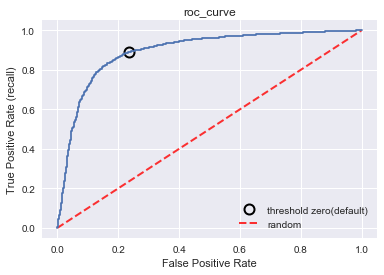

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
         label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='--', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");
from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr));

In [29]:
logreg = LogisticRegression(class_weight="balanced", random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(logreg, param_grid, scoring="roc_auc", cv=5)
logreg_train = grid.fit(X_train, y_train)
print(grid.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [31]:
pred_logreg = logreg_train.predict(X_test)
print("Train AUC score  is: ", grid.score(X_train, y_train)) # since we train a classifier based on AUC, print AUC score
print("Test AUC  score is: ", grid.score(X_test, y_test))


confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)
print("Classification accuray is: ", (confusion[0][0] + confusion[1][1]) / np.sum(confusion)) 

Train AUC score  is:  0.976494817259
Test AUC  score is:  0.901340273919
[[ 826  206]
 [ 468 3048]]
Classification accuray is:  0.851802990325


AUC score is:  0.901340273919


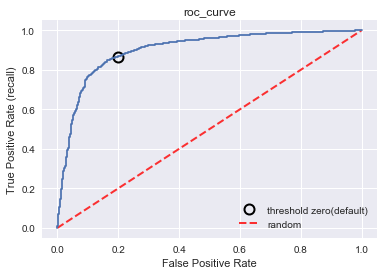

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
         label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='--', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");
from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr));

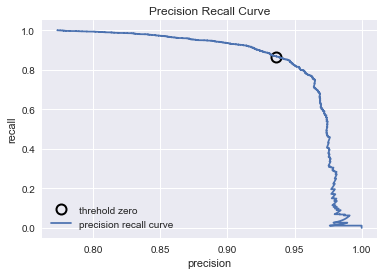

In [33]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(\
                                                      y_test, logreg_train.decision_function(X_test))
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, 
         label="threhold zero", fillstyle="none", c="k", mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("Precision Recall Curve")
plt.legend(loc="best");

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_logreg, 
                            target_names=["negative", "positive"]))

             precision    recall  f1-score   support

   negative       0.64      0.80      0.71      1032
   positive       0.94      0.87      0.90      3516

avg / total       0.87      0.85      0.86      4548



In [35]:
features_names = vect.get_feature_names()
print(len(features_names))
print("\n")
# print first 20 features
print(features_names[:20])
print("\n")
# print last 20 features
print(features_names[-20:])
print("\n")
# print every 400th word
print(features_names[::400])

26817


['00', '000', '00001', '0003', '000kwh', '000s', '001', '0060721855', '00pm', '01', '0174', '02', '020', '03', '030', '030712', '0312362919', '03755', '0393066304', '04']


['zits', 'ziwi', 'ziwipeak', 'zn', 'zoe', 'zofchak', 'zojirushi', 'zombie', 'zombies', 'zone', 'zoo', 'zooming', 'zucchini', 'zuke', 'zukes', 'zumba', 'zupreem', 'zylotol', 'zymox', 'zzzz']


['00', '2lbs', '96', 'afertaste', 'ample', 'asada', 'b000lkwxa4', 'baguette', 'benner', 'bolder', 'brunelle', 'cancelled', 'certainly', 'chop', 'collapse', 'consistancy', 'cramming', 'dalmation', 'density', 'disagree', 'doses', 'edged', 'epic', 'exported', 'fighting', 'foodshouldtastegood', 'furthermore', 'glycerine', 'growths', 'headaches', 'hops', 'impractical', 'integrated', 'jobs', 'kool', 'letdown', 'loved', 'marianne', 'metalic', 'monitoring', 'nauseated', 'nuked', 'orac', 'pamala', 'perches', 'plane', 'pps', 'protease', 'radioactive', 'reesesticks', 'reservoir', 'roller', 'saucepan', 'senses', 'sierra', 'snackmas

In [36]:
# min_df controls this condition(min_df=3 means pick up words which appear
# at least 3 documents)
vect = CountVectorizer(min_df=3).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)
print(repr(X_train))

<18190x11339 sparse matrix of type '<class 'numpy.int64'>'
	with 962857 stored elements in Compressed Sparse Row format>


In [37]:
features_names = vect.get_feature_names()
print(len(features_names))
print("\n")
# print first 20 features
print(features_names[:20])
print("\n")
# print last 20 features
print(features_names[-20:])
print("\n")
# print every 50th word
print(features_names[::400])

11339


['00', '000', '000kwh', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0g', '0mg', '10', '100', '1000', '100g', '105', '10g']


['zero', 'zest', 'zesty', 'zevia', 'zhena', 'zico', 'zinc', 'zing', 'zinger', 'zip', 'ziploc', 'ziplock', 'zipper', 'ziwipeak', 'zoe', 'zojirushi', 'zombie', 'zone', 'zuke', 'zukes']


['00', 'aerogrow', 'astronaut', 'blessing', 'cameron', 'cited', 'coolest', 'definitely', 'dot', 'evaluate', 'flattening', 'glorified', 'heathy', 'inflammatory', 'kosher', 'ma', 'miss', 'nutmeg', 'passages', 'posted', 'raging', 'retire', 'searched', 'smallest', 'steamed', 'tamales', 'towel', 'vegans', 'workplace']


In [38]:
logreg = LogisticRegression(class_weight="balanced", random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(logreg, param_grid, scoring="roc_auc", cv=5)
logreg_train = grid.fit(X_train, y_train)

print(grid.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [45]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
pred_logreg = logreg_train.predict(X_test)
confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)
print("Classification accuray is: ", (confusion[0][0] + confusion[1][1]) / np.sum(confusion)) 
print("Test AUC score is: ", auc(fpr, tpr));

[[ 804  228]
 [ 478 3038]]
Classification accuray is:  0.844766930519
Test AUC score is:  0.889643192581


In [46]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words is :", len(ENGLISH_STOP_WORDS), "\n")
print("Examples: ", list(ENGLISH_STOP_WORDS)[::10])

Number of stop words is : 318 

Examples:  ['nine', 'now', 'former', 'our', 'much', 'they', 'who', 'thereafter', 'whereafter', 'side', 'ltd', 'beyond', 'mill', 'already', 'someone', 'seems', 'mine', 'whose', 'but', 'un', 'us', 'indeed', 'nor', 'few', 'therefore', 'although', 'seemed', 'anyway', 'both', 'whether', 'amount', 'what']


In [47]:
vect = CountVectorizer(min_df=3, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)
print(repr(X_train))

<18190x11046 sparse matrix of type '<class 'numpy.int64'>'
	with 539369 stored elements in Compressed Sparse Row format>


In [48]:
logreg = LogisticRegression(class_weight="balanced", random_state=0)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(logreg, param_grid, scoring="roc_auc", cv=5)
logreg_train = grid.fit(X_train, y_train)

print(grid.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [49]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
print("Train AUC is: ", grid.score(X_train, y_train))
print("Test AUC is: ", grid.score(X_test, y_test))

pred_logreg = logreg_train.predict(X_test)

confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)

print("Test AUC score is: ", auc(fpr, tpr)); # same as grid.score(X_test, y_test)

Train AUC is:  0.967326095903
Test AUC is:  0.889643192581
[[ 804  228]
 [ 478 3038]]
AUC score is:  0.889643192581


# TFIDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [51]:
logreg = LogisticRegression(class_weight="balanced", random_state=0)
pipe = make_pipeline(TfidfVectorizer(norm=None, stop_words='english'), logreg)
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=5)
logreg_train = grid.fit(text_train, y_train)

In [52]:
print(grid.best_estimator_)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=None, preprocessor=None, smooth_i...nalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


In [56]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(text_test))
pred_logreg = logreg_train.predict(text_test)
confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)
print("Classification accuray is: ", (confusion[0][0] + confusion[1][1]) / np.sum(confusion)) 
print("AUC score is: ", auc(fpr, tpr));

[[ 806  226]
 [ 454 3062]]
Classification accuray is:  0.850483729112
AUC score is:  0.894932413066


In [57]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(text_train)
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

feature_names = np.array(vectorizer.get_feature_names())

print("features with lowest tfidf")
print(feature_names[sorted_by_tfidf[:20]], '\n')

print("featues with hightest tfidf")
print(feature_names[sorted_by_tfidf[-20:]])

features with lowest tfidf
['pricey' 'agree' 'sitting' 'overpowering' 'saying' 'sorry' 'share'
 'appreciate' 'fell' 'according' 'disappointing' 'staple' 'terrific'
 'enjoyable' 'bonus' 'searching' 'regularly' 'incredibly' 'delightful'
 'typically'] 

featues with hightest tfidf
['dioxide' 'echinacea' 'scalp' 'scotch' 'sriracha' 'nirvana' 'scoville'
 'trap' 'rooibos' 'titanium' 'blade' 'pizza' 'oils' 'br' 'olive' '12'
 'bisquick' 'carmel' 'bbd' 'wut']


In [58]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("features with lowest idf")
print(feature_names[sorted_by_idf[:100]])

features with lowest idf
['like' 'good' 'br' 'great' 'just' 'taste' 'product' 'love' 'flavor'
 'really' 'amazon' 'don' 'coffee' 'time' 'little' 'buy' 've' 'use' 'best'
 'tried' 'price' 'food' 'try' 'better' 'make' 'eat' 'tea' 'bought' 'used'
 'way' 'bag' 'think' 'recommend' 'cup' 'tastes' 'sweet' 'day' 'store' 'did'
 'delicious' 'know' 'sugar' 'free' 'favorite' 'bit' 'order' 'box' 'nice'
 'got' 'does' 'drink' 'dog' 'water' 'want' 'makes' 'loves' 'flavors' 'say'
 'right' 'chocolate' 'years' 'lot' 'small' 'different' 'll' 'perfect'
 'healthy' 'ordered' 'quality' 'doesn' 'stuff' 'didn' 'brand' 'sure' 'add'
 'buying' 'old' 'bad' 'need' 'using' 'enjoy' 'mix' 'pack' 'long' 'snack'
 'hard' 'hot' 'easy' 'products' 'high' 'definitely' 'strong' 'ingredients'
 'thing' 'thought' 'far' 'fresh' 'pretty' 'eating' 'actually']


In [59]:
import mglearn

Text(0.5,1,'tfidf-cofficient')

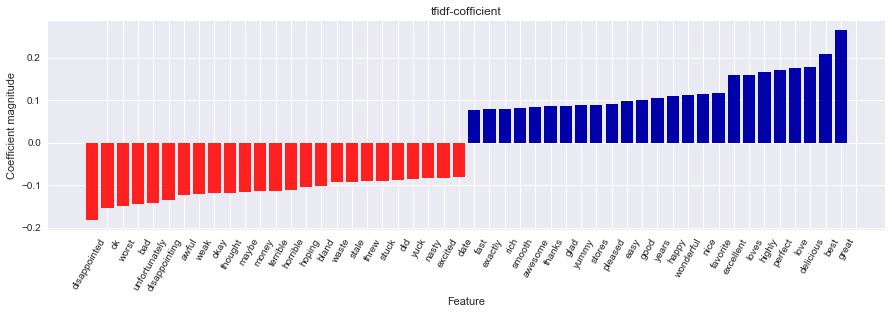

In [60]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, 
                                   feature_names, n_top_features=25)
plt.title("tfidf-cofficient")

In [62]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(class_weight="balanced", random_state=0))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 10, 100], 
              'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)]}

grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=5)
logreg_train = grid.fit(text_train, y_train)
print("Best cross-validation AUC score: ", grid.best_score_)
print("Bes parameter is: ", grid.best_params_)

Best cross-validation AUC score:  0.936234431552
Bes parameter is:  {'tfidfvectorizer__ngram_range': (1, 3), 'logisticregression__C': 10}


In [63]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(text_test))
pred_logreg = logreg_train.predict(text_test)
confusion = confusion_matrix(y_test, pred_logreg)
print(confusion)
print("Classification accuray is: ", (confusion[0][0] + confusion[1][1]) / np.sum(confusion)) 
print("AUC score is: ", auc(fpr, tpr));

[[ 810  222]
 [ 261 3255]]
Classification accuray is:  0.893799472296
AUC score is:  0.93822426383


AUC score is:  0.93822426383


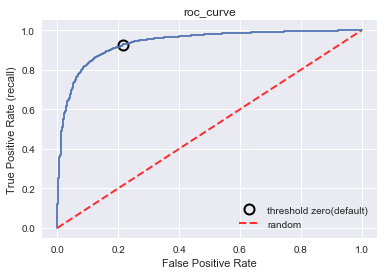

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(text_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
         label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='--', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");
print("AUC score is: ", auc(fpr, tpr))

In [65]:
from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr))

AUC score is:  0.93822426383


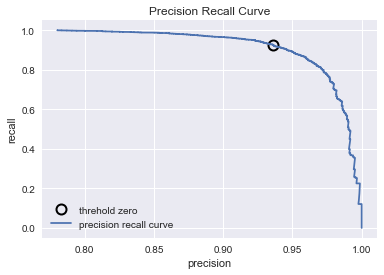

In [66]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(\
                                                      y_test, logreg_train.decision_function(text_test))
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, 
         label="threhold zero", fillstyle="none", c="k", mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("Precision Recall Curve")
plt.legend(loc="best");

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_logreg, 
                            target_names=["negative", "positive"]))

             precision    recall  f1-score   support

   negative       0.76      0.78      0.77      1032
   positive       0.94      0.93      0.93      3516

avg / total       0.90      0.89      0.89      4548



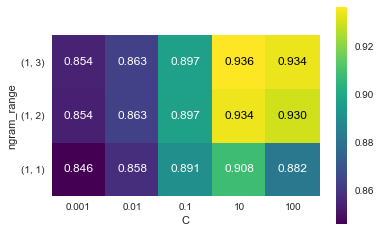

In [68]:
scores = [s for s in grid.cv_results_['mean_test_score']]
scores = np.array(scores).reshape(-1, 3).T
heatmap = mglearn.tools.heatmap(scores, xlabel="C", ylabel="ngram_range", 
                               xticklabels=param_grid["logisticregression__C"], 
                               yticklabels=param_grid["tfidfvectorizer__ngram_range"], 
                               cmap="viridis", fmt="%.3f")
plt.colorbar(heatmap)

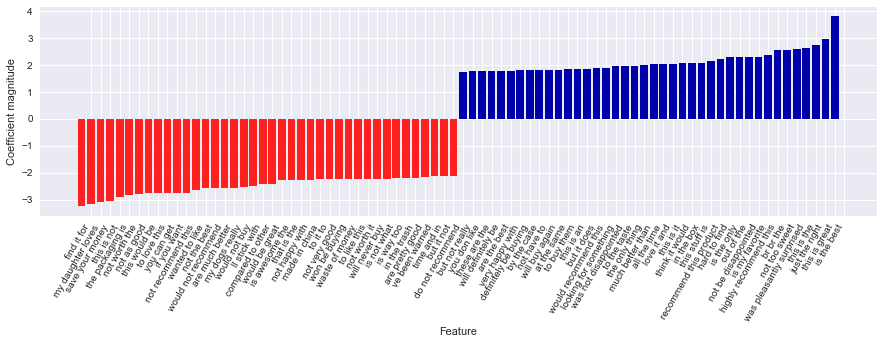

In [69]:
feature_names = np.array(grid.best_estimator_.named_steps["tfidfvectorizer"].get_feature_names())
coef = grid.best_estimator_.named_steps["logisticregression"].coef_
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
mglearn.tools.visualize_coefficients(coef.ravel()[mask], 
                                   feature_names[mask], n_top_features=40)

<h2>Inspect words for each positive/negative reviews</h2>

In [103]:
from collections import Counter

# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()


# TODO: Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i, text in enumerate(reduced_texts):
    if reduced_labels[i] == 1:
        for word in text.split(' '):
            positive_counts[word] +=1
            total_counts[word] +=1
    else:
        for word in text.split(' '):
            negative_counts[word] += 1
            total_counts[word] += 1

In [104]:
print(reduced_texts.shape)

(22738,)


In [105]:
reduced_sentiment_pct

array([ 0.22174334,  0.77825666])

In [106]:
# Create Counter object to store positive/negative ratios
pos_neg_ratios = Counter()

# TODO: Calculate the ratios of positive and negative uses of the most common words
#       Consider words to be "common" if they've been used at least 100 times

for word in positive_counts:
    if positive_counts[word] >= 100 and negative_counts[word] >= 100:
        pos_neg_ratios[word] = positive_counts[word] / negative_counts[word]

for word, ratio in pos_neg_ratios.most_common():
    if(ratio > 1):
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))

In [107]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'good' = {}".format(pos_neg_ratios["good"]))
print("Pos-to-neg ratio for 'bad' = {}".format(pos_neg_ratios["bad"]))

Pos-to-neg ratio for 'the' = 0.9659791633936624
Pos-to-neg ratio for 'good' = 1.3656194673889341
Pos-to-neg ratio for 'bad' = 0.28007747306656167


In [108]:
pos_neg_ratios.most_common()[:10]

[('loves', 2.3643542963828121),
 ('best', 2.2720257904189176),
 ('great', 2.2582335927764534),
 ('favorite', 2.0803809499217718),
 ('happy', 1.9659241593253818),
 ('love', 1.9211982659812199),
 ('healthy', 1.8902784530691645),
 ('snack', 1.8624124365517525),
 ('every', 1.8092818199202574),
 ('nice', 1.8054771054568544)]

In [109]:
# words most frequently seen in a review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[:10]

[('disappointed', -0.89159811928378352),
 ('away.', 0.0093023926623134103),
 ('NOT', 0.009950330853168092),
 ('cans', 0.044672440051592599),
 ('money', 0.051031480012445826),
 ('excited', 0.076961041136128394),
 ('opened', 0.084706697472162751),
 ('thought', 0.17999481484347843),
 ("wasn't", 0.24419696051204215),
 ('received', 0.25521168742099676)]

In [110]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

<h2>There are many neutral meaning words which could be eliminated</h2>

In [111]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

<h2>There are some words occurring frequently</h2>

In [112]:
frequency_frequency = Counter()

for word, cnt in total_counts.most_common():
    frequency_frequency[cnt] += 1
    
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

In [113]:
pos_neg_ratios.most_common()[:3]

[('loves', 2.3643542963828121),
 ('best', 2.2720257904189176),
 ('great', 2.2582335927764534)]

In [114]:
pos_neg_ratios["I"]

1.0432450790443935

In [115]:
total_counts.most_common()[:100]

[('the', 65735),
 ('I', 55918),
 ('and', 49216),
 ('a', 47265),
 ('', 40151),
 ('to', 40086),
 ('of', 31745),
 ('is', 28688),
 ('it', 25423),
 ('for', 20709),
 ('in', 20684),
 ('this', 19581),
 ('that', 16146),
 ('my', 14659),
 ('with', 13952),
 ('have', 13538),
 ('but', 13235),
 ('was', 12443),
 ('are', 12438),
 ('not', 11419),
 ('you', 11202),
 ('/><br', 10252),
 ('on', 10198),
 ('as', 10111),
 ('like', 9582),
 ('so', 8134),
 ('they', 8106),
 ('The', 7848),
 ('be', 7271),
 ('or', 6890),
 ('at', 6684),
 ('these', 6377),
 ('just', 6127),
 ('them', 6012),
 ('very', 5852),
 ('from', 5541),
 ('good', 5528),
 ('It', 5511),
 ('one', 5495),
 ('This', 5427),
 ('has', 5162),
 ('can', 5101),
 ('taste', 4966),
 ('would', 4803),
 ('all', 4690),
 ('had', 4667),
 ('will', 4650),
 ('more', 4610),
 ('than', 4419),
 ('when', 4359),
 ('love', 4353),
 ('coffee', 4337),
 ('great', 4311),
 ('if', 4278),
 ('get', 4111),
 ('other', 4096),
 ('about', 4067),
 ('product', 3964),
 ('out', 3895),
 ('really', 384